## Webscrapping Data from Wikipedia to plot the nominal GDP of the first 10 countries on the list ##

I wanted to make a little web-scrapping project to learn some useful feautures in both BeautifulSoup and the Matplotlib library. For this, I decided to make a project that would: 

- Scrape data from wikipedia 
- Clean it
- Organize it into a Dataframe 
- Plot it 
- Format it 

In [1]:
# importing the relevant libraries 

import requests 
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# web scrapping List of Countries by GDP from Wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)#Table"

request_1 = requests.get(wiki_url)

soup = BeautifulSoup(request_1.text, "html.parser")
table1= soup.find('table', attrs={'class': "wikitable"})

df = pd.read_html(str(table1))[0]


I used the re (Regular expressions) library to clean the data of notes and any additional formatting using a function and then mapping the result to all the code. 


In [3]:
#This pattern matches any text that starts with "[", followed by one or more digits and ends with "]", so it will match notes like "[1]", "[13]", "[14]", etc.
#+ quantifier makes the match to be one or more digits,

#snipet of code to delete the note tags from the DataFrame

df = df.rename(columns=lambda x: re.sub(r"\[\d+\]", "", x))
def remove_notes(x):
    return re.sub(r"\s?\[.*?\]", "", x)

df = df.applymap(remove_notes)


In [4]:
#Slicing to get only data from the WB 
df1 = df["World Bank"]
#Slicing to solve the multi-index created by scrapping 
df2 = df["Country/Territory"]
#concanating the result to df1 to add 'Country/Territory'
df1 = pd.concat([df1, df2['Country/Territory']], axis=1)
#merging on C/T
merged_df = pd.merge(df1, df2, on='Country/Territory')

#dropping the "World" row
merged_df = merged_df.drop(merged_df.index[0])
merged_df

#converting GDP estimates to floats 
merged_df['Estimate'] = pd.to_numeric(merged_df['Estimate'], errors='coerce')

#dividing by a thousand to get the GDP numbers in billions 
merged_df['Estimate'] = merged_df['Estimate']/1_000

In [5]:
#Dictionary containing individual colors for each country in RGB
flag_colors = {'United States': [255, 0, 0], 
               'China': [255, 255, 0], 
               'Japan': [0, 0, 255],
               'Germany': [0, 0, 0],
               'India': [255, 153, 51], 
               'United Kingdom': [0, 0, 153],
               'France': [255, 0, 255],
               'Canada': [51, 153, 255],
               'Russia': [255, 153, 153],
               'Italy': [153, 0, 0]
               }


#converting to RGBA and saving all to "colors"
flag_colors = {k: [color/255 for color in v] for k,v in flag_colors.items()}
flag_colors = {k: v + [0.5] for k, v in flag_colors.items()}
colors = [flag_colors[x] for x in flag_colors]

# Create a list of patches for each country
patches = [plt.Rectangle((-1,-1),1,1,color=flag_colors[x]) for x in flag_colors]


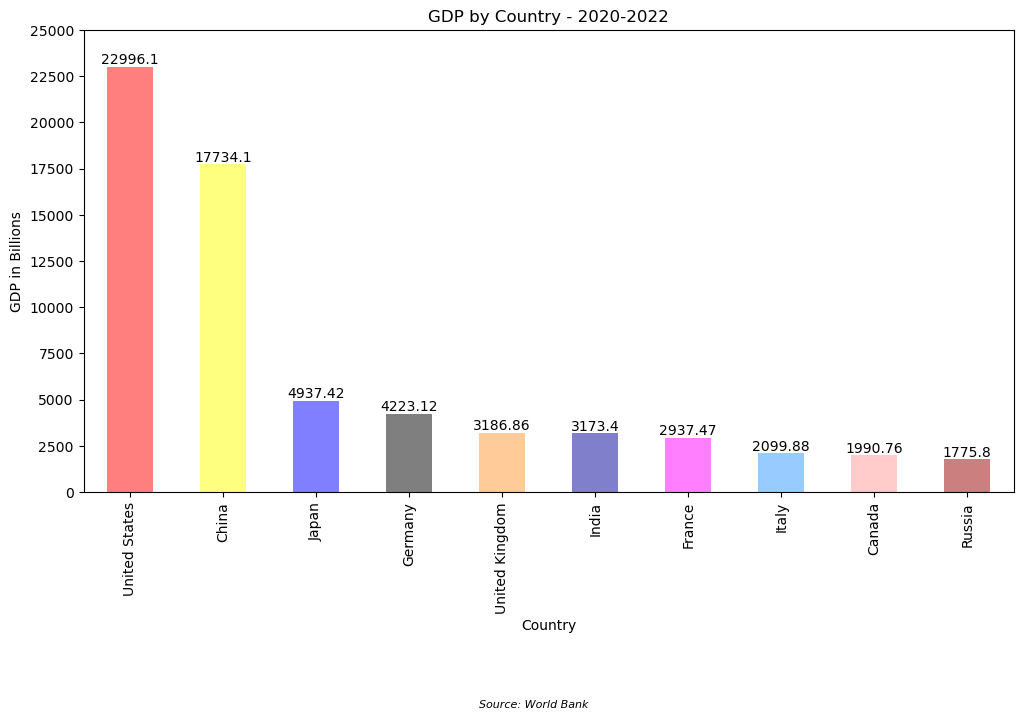

In [9]:
#figure size 1200x600 px
fig, ax = plt.subplots(figsize=(12,6))
#plotting the first 10 values
merged_df.head(10).sort_values(by=['Estimate'], ascending=False).plot(kind='bar', x='Country/Territory', y='Estimate', color=colors, ax=ax, legend="GDP")
#labelling
ax.set_xlabel('Country')
ax.set_ylabel('GDP in Billions')
#Setting axis range and step
ax.set_ylim(0,25000)
plt.yticks(np.arange(0, 25000+1, 2500))
ax.set_title('GDP by Country - 2020-2022')
#Hiding legend 
plt.legend().set_visible(False)
#Adding source
txt="Source: World Bank"
fig.text(.5, -0.25, txt, wrap=True, style='italic', horizontalalignment='center', fontsize=8)

#adding GDP values on top of bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10)
plt.show()